<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif-:" data-toc-modified-id="Objectif-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Script" data-toc-modified-id="Script-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Script</a></span></li></ul></li><li><span><a href="#Analyse-de-la-feature" data-toc-modified-id="Analyse-de-la-feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse de la feature</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-dépot-suivant-les-stations" data-toc-modified-id="Analyse-des-dépot-suivant-les-stations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse des dépot suivant les stations</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np

from vcub_keeper.reader.reader import *
from vcub_keeper.visualisation import plot_station_activity

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Objectif :

- Création d'une features afin de connaitre le nombre d'ajout de vélo qu'il y a eu pour une même station entre 2 points temporels. cf https://github.com/armgilles/vcub_keeper/issues/4
- Industrialisation de la fonction
- Analyse des résultats

## Dev

In [2]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [3]:
activite.head()

,gid,station_id,type,name,state,available_stands,available_bikes,date
0,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:03:04
1,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:04:04
2,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:09:04
3,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:14:03
4,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:19:04


In [4]:
activite['available_bikes_shift'] = \
    activite.groupby('station_id')['available_bikes'].shift(1)

activite['available_bikes_shift'] = activite['available_bikes_shift'].fillna(activite['available_bikes'])

activite['transactions_in'] = activite['available_bikes'] - activite['available_bikes_shift']

activite.loc[activite['transactions_in'] < 0,
            'transactions_in'] = 0

In [5]:
activite[136025:136050]

,gid,station_id,type,name,state,available_stands,available_bikes,date,available_bikes_shift,transactions_in
136025,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 10:55:03,3.0,0.0
136026,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:00:03,2.0,0.0
136027,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:05:04,2.0,0.0
136028,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:10:04,2.0,0.0
136029,86,7,VLS,Palais de Justice,1,17,1,2017-08-02 11:15:03,2.0,0.0
136030,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:25:04,1.0,1.0
136031,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:30:06,2.0,0.0
136032,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:35:04,2.0,0.0
136033,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:40:05,2.0,0.0
136034,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:45:03,2.0,0.0


## Industrialisation

In [6]:
import pandas as pd 

def get_transactions_in(data):
    """
    Calcul le nombre d'ajout de vélo qu'il y a eu pour une même station entre 2 points de données

    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub

    Returns
    -------
    data : DataFrame
        Ajout de colonne 'transactions_in'

    Examples
    --------

    activite = get_transactions_in(activite)
    """

    data['available_bikes_shift'] = \
        data.groupby('station_id')['available_bikes'].shift(1)

    data['available_bikes_shift'] = data['available_bikes_shift'].fillna(data['available_bikes'])

    data['transactions_in'] = data['available_bikes'] - data['available_bikes_shift']

    data.loc[data['transactions_in'] < 0,
             'transactions_in'] = 0

    # Drop non usefull column
    data.drop('available_bikes_shift', axis=1, inplace=True)

    return data

In [7]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_in(activite)

In [8]:
activite[136025:136050]

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
136025,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 10:55:03,0.0
136026,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:00:03,0.0
136027,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:05:04,0.0
136028,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:10:04,0.0
136029,86,7,VLS,Palais de Justice,1,17,1,2017-08-02 11:15:03,0.0
136030,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:25:04,1.0
136031,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:30:06,0.0
136032,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:35:04,0.0
136033,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:40:05,0.0
136034,86,7,VLS,Palais de Justice,1,16,2,2017-08-02 11:45:03,0.0


### Script

In [9]:
from vcub_keeper.reader.reader import *
from vcub_keeper.transform.features_factory import get_transactions_in

In [10]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_in(activite)

In [11]:
activite[436025:436050]

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
436025,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:25:03,0.0
436026,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:30:05,0.0
436027,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:35:04,0.0
436028,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:40:03,0.0
436029,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:45:03,0.0
436030,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:50:03,0.0
436031,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 08:55:04,0.0
436032,91,21,VLS,Puy Paulin,1,14,1,2017-07-22 09:00:03,0.0
436033,91,21,VLS,Puy Paulin,1,12,3,2017-07-22 09:05:04,2.0
436034,91,21,VLS,Puy Paulin,1,12,3,2017-07-22 09:10:04,0.0


## Analyse de la feature

In [12]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_in(activite)

In [13]:
activite['transactions_in'].describe()

count    3.761880e+06
mean     1.280222e-01
std      5.084186e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.400000e+01
Name: transactions_in, dtype: float64

/home/gillesa/anaconda3/envs/vcub_keeper/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='transactions_in'>

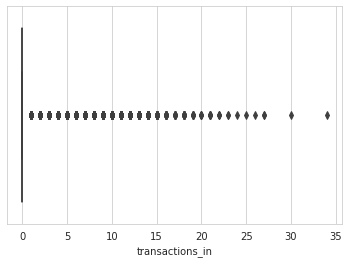

In [14]:
sns.boxplot(activite['transactions_in'])

/home/gillesa/anaconda3/envs/vcub_keeper/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='transactions_in', ylabel='Density'>

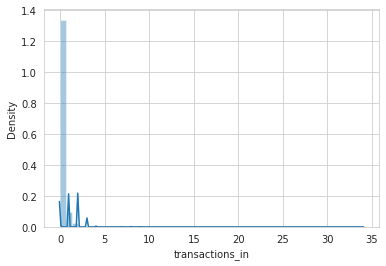

In [15]:
sns.distplot(activite['transactions_in'])

### Analyse des dépot suivant les stations

In [16]:
ajout_by_station = \
    activite.groupby('station_id',
                     as_index=False)['transactions_in'].agg({'max': 'max',
                                                             'mean': 'mean',
                                                             'median': 'median',
                                                             'min': 'min',
                                                             'std': 'std',
                                                             'var': 'var',
                                                             'skew': 'skew',
                                                             '25%': lambda x: x.quantile(0.25),
                                                             '75%': lambda x: x.quantile(0.75),
                                                             '95%':  lambda x: x.quantile(0.95)
                                                             })

ajout_by_station.sort_values('mean', ascending=0, inplace=True)

In [17]:
ajout_by_station

,station_id,max,mean,median,min,std,var,skew,25%,75%,95%
105,106,21.0,0.565402,0.0,0.0,1.436742,2.064227,4.793953,0.0,1.0,3.0
4,5,34.0,0.447965,0.0,0.0,1.123620,1.262522,6.358837,0.0,0.0,2.0
21,22,20.0,0.433349,0.0,0.0,0.967461,0.935980,3.590204,0.0,0.0,2.0
122,123,22.0,0.417160,0.0,0.0,1.265391,1.601213,6.217226,0.0,0.0,2.0
38,39,25.0,0.416512,0.0,0.0,1.089252,1.186470,5.404568,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
159,160,3.0,0.001156,0.0,0.0,0.041354,0.001710,43.742844,0.0,0.0,0.0
75,76,1.0,0.000046,0.0,0.0,0.006801,0.000046,147.037410,0.0,0.0,0.0
92,93,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
136,137,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# Station les plus active sur les dépôt de vélo
plot_station_activity(activite, station_id=106, features_to_plot=['transactions_in'])

In [21]:
activite.tail()

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
3761875,176,174,VLS,Darwin,1,1,19,2017-09-26 14:39:02,0.0
3761876,176,174,VLS,Darwin,1,0,20,2017-09-26 14:44:05,1.0
3761877,176,174,VLS,Darwin,1,0,20,2017-09-26 14:49:05,0.0
3761878,176,174,VLS,Darwin,1,0,20,2017-09-26 14:54:04,0.0
3761879,176,174,VLS,Darwin,1,0,20,2017-09-26 14:59:04,0.0


In [ ]:
plot_station_activity(activite, station_id=5, features_to_plot=['available_bikes'],
                      start_date='2017-08-22', end_date='2017-08-30')

# Test

In [23]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_in

In [28]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [29]:
activite = get_transactions_in(activite)

In [30]:
activite["date"].min()

Timestamp('2017-07-09 00:03:04')

In [32]:
activite[activite["transactions_in"] > 0].head(15)

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_in
41,83,1,VLS,Meriadeck,1,19,1,2017-07-09 03:24:05,1.0
43,83,1,VLS,Meriadeck,1,18,2,2017-07-09 03:34:04,1.0
46,83,1,VLS,Meriadeck,1,16,4,2017-07-09 03:49:03,2.0
57,83,1,VLS,Meriadeck,1,16,4,2017-07-09 04:44:04,1.0
58,83,1,VLS,Meriadeck,1,15,5,2017-07-09 04:49:04,1.0
60,83,1,VLS,Meriadeck,1,14,6,2017-07-09 04:59:05,1.0
69,83,1,VLS,Meriadeck,1,13,7,2017-07-09 05:44:04,1.0
77,83,1,VLS,Meriadeck,1,12,8,2017-07-09 06:24:05,1.0
82,83,1,VLS,Meriadeck,1,12,8,2017-07-09 06:49:04,1.0
102,83,1,VLS,Meriadeck,1,13,7,2017-07-09 08:29:04,1.0


In [43]:
# activite[(activite["transactions_out"] > 1) & (activite["date"] == "2017-07-09 11:09:04")].head()
# activite[(activite["date"] >= "'2017-07-09 03:24:05'") & (activite["station_id"] == 1)].head(11).to_dict(orient="list")
activite[(activite["date"] >= "2017-07-09 00:54:05") & (activite["station_id"] == 22)].head(11).to_dict(orient="list")

{'gid': [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
 'station_id': [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
 'type': ['VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS'],
 'name': ['Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville'],
 'state': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'available_stands': [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
 'available_bikes': [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
 'date': [Timestamp('2017-07-09 00:54:05'),
  Timestamp('2017-07-09 00:59:04'),
  Timestamp('2017-07-09 01:04:04'),
  Timestamp('2017-07-09 01:09:03'),
  Timestamp('2017-07-09 01:14:04'),
  Timestamp('2017-07-09 01:19:04'),
  Timestamp('2017-07-09 01:24:04'),
  Timestamp('2017-07-09 01:29:04'),
  Timestamp('2017-07-09 01:34:04'),
  Timestamp('2017-07-09 01:39:04'),
  Timestamp('

In [ ]:
{'gid': [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
 'station_id': [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
 'type': ['VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS'],
 'name': ['Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville'],
 'state': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'available_stands': [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
 'available_bikes': [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
 'date': [Timestamp('2017-07-09 00:54:05'),
  Timestamp('2017-07-09 00:59:04'),
  Timestamp('2017-07-09 01:04:04'),
  Timestamp('2017-07-09 01:09:03'),
  Timestamp('2017-07-09 01:14:04'),
  Timestamp('2017-07-09 01:19:04'),
  Timestamp('2017-07-09 01:24:04'),
  Timestamp('2017-07-09 01:29:04'),
  Timestamp('2017-07-09 01:34:04'),
  Timestamp('2017-07-09 01:39:04'),
  Timestamp('2017-07-09 01:44:05')],
 'transactions_in': [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]}

In [46]:
data = {
    "gid" : [83] * 11 + [92] * 11,
    "station_id" : [1] * 11 + [22] * 11,
    "type" : ['VLS'] * 11 + ['VLS'] * 11,
    "name" : ['Meriadeck'] * 11 + ["Hotel de Ville"] * 11,
    "state" : [1] * 11 + [1] * 11,
    "available_stands" : [19, 19, 18, 18, 18, 16, 16, 16, 16, 17, 17] +
        [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes" : [1, 1, 2, 2, 2, 4, 4, 4, 4, 3, 3] +
        [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date" : [pd.Timestamp('2017-07-09 03:24:05'),
  pd.Timestamp('2017-07-09 03:29:04'),
  pd.Timestamp('2017-07-09 03:34:04'),
  pd.Timestamp('2017-07-09 03:39:04'),
  pd.Timestamp('2017-07-09 03:44:05'),
  pd.Timestamp('2017-07-09 03:49:03'),
  pd.Timestamp('2017-07-09 03:54:04'),
  pd.Timestamp('2017-07-09 03:59:03'),
  pd.Timestamp('2017-07-09 04:04:06'),
  pd.Timestamp('2017-07-09 04:09:04'),
  pd.Timestamp('2017-07-09 04:14:04')] +
        [pd.Timestamp('2017-07-09 00:54:05'),
  pd.Timestamp('2017-07-09 00:59:04'),
  pd.Timestamp('2017-07-09 01:04:04'),
  pd.Timestamp('2017-07-09 01:09:03'),
  pd.Timestamp('2017-07-09 01:14:04'),
  pd.Timestamp('2017-07-09 01:19:04'),
  pd.Timestamp('2017-07-09 01:24:04'),
  pd.Timestamp('2017-07-09 01:29:04'),
  pd.Timestamp('2017-07-09 01:34:04'),
  pd.Timestamp('2017-07-09 01:39:04'),
  pd.Timestamp('2017-07-09 01:44:05')],
    "transactions_in" : [0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0] +
        [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
}

df_activite = pd.DataFrame(data)
# drop columns we want to test.
df_activite = df_activite.drop(columns=["transactions_in"], axis=1)

result = get_transactions_in(df_activite)

expected = pd.DataFrame(data)

pd.testing.assert_frame_equal(result, expected)